## Chapter 7　実装

---
### 7.1　GPUとGPGPU
画像に対するGPU利用と比べて自然言語処理分野ではGPU利用が難しかったが、  
近年GPUを利用するための手法が発展してきた。

GPU利用には計算の並列化が重要であり、その代表はミニバッチ化である。

---
### 7.2　RNNにおけるミニバッチ化
自然言語処理においてミニバッチ化を妨げていた問題は  
入力文や出力文の長さが一定でないということである。

古くから文長ごとにデータセットを分割する手法はあったが、これは無作為抽出を不可能にするため  
モデルの予測能力に深刻な悪影響を与えることがある。

そこで考えられたのが padding を文へ適用することで、  
nullなど事前に定めた特殊な単語を付加することで文長を揃え並列計算を効率化する。    
ただし、全ての文がミニバッチ中の最大長に揃えられることになるため、計算量そのものは増大する。

また、文長によりソートすることで並列計算における無駄な分岐を減らすことができるので、  
これも計算速度向上に寄与する。  

paddngによる計算量増大を軽減するためにミニバッチごとに文長を選択して  
それぞれの文長に合わせた計算グラフを事前に準備することで計算時間を減らすテクニックがあり、  
これをバケッティング（bucketing）という。  
ただし、文長の種類が多いと計算グラフを事前準備する意味は失われていく。

---
#### 多層のRNNの高速化
RNNにおいて時刻 $t$ における $k$ 番目の層の出力を $\mathbf{h}_{t}^{(k)}$ と表記する。  
時刻 $t$ または層の番号 $k$ が一致する２つの出力は依存性が存在するために並列計算できないが、  
$t$ と $k$ の両方が異なれば依存関係が存在しないため、理論的には並列計算可能である。

J.Appleyard et al. [Optimizing Performance of Recurrent Neural Networks on GPUs](https://arxiv.org/abs/1604.01946) arXiv:1604.01946 [cs.LG] 2016.  
ではRNNに種々の計算効率改善策を実装し、最大11倍の高速化を果たしたと報告されている。

---
#### 持続性再帰ニューラルネット （persistent RNN）
RNNの隠れ状態ベクトルを $\mathbf{h} \in \mathbb{R}^{D}$、バッチ数を $B$ とする。  
このとき隠れ状態ベクトルとパラメータ行列の積の時間計算量は $O(BD^{2})$、  
GPUにおけるメモリの消費量は $O(D^{2})$ である。

計算中プロセッサ上のレジスタに行列を保持して読み込み時間を抑える  
持続性再帰ニューラルネットという手法が提案されている。

---
#### 木構造再帰ニューラルネットのミニバッチ化
Tree-RNNの単純なミニバッチ化は困難である。

再帰的な伝播計算を、スタックを用いる直列的な計算に変換することを考える。  
各ノードに木の帰りがけ順に番号を振り、番号の小さい順にたどりながら処理を行うこととする。

葉ノードに対して埋め込みベクトルを計算する操作を $\Lambda$、  
各ノードに対して２つの子ノードの隠れ状態ベクトル $\mathbf{h}_{L}, \mathbf{h}_{R}$ から  
親ノードの隠れ状態ベクトル $\mathbf{h}_{P}$ を計算する操作を $\Psi$ とする。

帰りがけ順にノードをたどるとき、葉ノードで $\Lambda$ を、それ以外のノードで $\Psi$ を行えばよい。  
この操作はスタックを利用した木構造の走査と見なすことができるので、  
$\Lambda$ では計算結果をプッシュし、 $\Psi$ ではポップ操作で２データを読み込み計算結果をプッシュする。

各ステップでどの変数に $\Lambda, \Psi$ いずれの操作を行うかがわかれば並列化可能である。  
これは上記のようなスタックの情報 $\{ \mathbf{h}_{i} \}$ を保持すれば可能である。

文長 $I$ について $\{\mathbf{h}_{i}\}$ の大きさは $2I-1$、各要素は $\mathbf{h}_{i} \in \mathbb{R}^{D}$ であり、  
各ステップごとに複製が必要であるから、前向き計算で $O(I^{2}D)$ のメモリを消費する。  
これはシンスタック（thin stack）により空間計算量を $O(ID)$ まで減らすことができる。

---
### 7.3　無作為抽出
自然言語処理のための各種モデルをはじめとして、無作為抽出は近似計算のために頻用される。

---
#### 逆関数法 （inverse transform sampling）
目的の確率分布の累積分布関数を $F(\cdot)$、$(0,1)$ 上の一様関数に従う確率変数を $U$ とすると  
$F^{-1}(U)$ は目的の確率分布に従う。  
よって $(0,1)$ 上の一様分布から無作為抽出した $r$ を用いて $F^{-1}(r)$ を計算すると目的の分布からの標本となる。

$F^{-1}$ が陽に計算できる場合には容易に並列計算可能である。

---
#### ガンベル最大トリック （Gumbel-max trick）
$N$ 個の単語に対して $\{ u_{1}, \ldots, u_{N} \}$ が与えられたときに  
確率 $p_{k} = \frac{\exp u_{k}}{\sum_{i=1}^{N} \exp u_{i}}$ に従って無作為抽出することを考える。

ガンベル分布 $Gb(0,1)$ に従って $N$ 個の値 $\{G_{1}, \ldots, G_{N}\}$ を独立に無作為抽出する。  
このとき累積分布関数 $F(\cdot)$ と確率密度関数 $f(\cdot)$ は次の通り。

\begin{align*}
F(x) &= \exp(-\exp(-x)) \\
f(x) &= \exp(-x)\exp(-\exp(-x)) \\
&= \exp (-x) F(x)
\end{align*}

ガンベル分布からの抽出は、逆関数法を使い  
累積分布関数の逆関数 $F^{-1}(x) = - \log(- \log x)$ に  
$(0,1)$ 一様分布からの乱数を入力することで得られる。

ここで $Z_{i} = u_{i} + G_{i}$ とおくと、  
$Z_{k}$ が $\{X_{1}, \ldots, Z_{N}\}$ の中で最大となる確率は $p_{k}$ に一致する。

\begin{align*}
P(Z_{i} < Z_{k}, \hspace{4pt} \forall i, \hspace{4pt} i \neq k) = p_{k}
\end{align*}

アルゴリズムは次のようにまとめられる。

\begin{align*}
\hline
& \text{for} \hspace{5pt} i := 1, \ldots, N \hspace{5pt} \text{do} \\
& \hspace{20pt} r_{i} \sim U(0,1) \\
& \hspace{20pt} g_{i} = -\log(-\log r_{i}) \\
& \hspace{20pt} z_{i} = u_{i} + g_{i} \\
&\text{end for} \\
&k = \operatorname{argmax}_{i} z_{i} \\
&\text{return} \hspace{5pt} k \\
&\hline
\end{align*}

E.Jang et al. [Categorical Reparameterization with Gumbel-Softmax](https://arxiv.org/abs/1611.01144) 	arXiv:1611.01144 [stat.ML] 2016.  
では、Gumbel-Max trick から argmax以降の処理を省略し  
分布から直接 one-hot なベクトルをサンプリングできる Gumbel-Softmax Distribution を提案している。

　参考：[Categorical Reparameterization with Gumbel-Softmax [arXiv:1611.01144] | ご注文は機械学習ですか？](http://musyoku.github.io/2016/11/12/Categorical-Reparameterization-with-Gumbel-Softmax/)

---
#### 補記：ガンベル(極値)分布 (Gumbel distribution)
互いに独立で同一の何らかの分布に従う標本における最大値を新たな確率変数 $X$ とみなしたとき  
その確率変数 $X$ が漸近的に従う分布である。  
一般極値分布 (Generalized Extreme Value) のタイプ１に相当する。

位置パラメータを $\mu \in \mathbb{R}$、尺度パラメータを $\theta > 0$ として、  
ガンベル分布 $Gb(\mu,\theta)$ の確率密度関数は次の通り。

\begin{align*}
f(x) &= \frac{1}{\theta} e^{- \frac{x-\mu}{\theta}} e^{-e^{- \frac{x-\mu}{\theta}}} & (-\infty<x<\infty)
\end{align*}

また、累積分布関数は次の通り。

\begin{align*}
F(x) = e^{-e^{- \frac{x-\mu}{\theta}}}
\end{align*}

期待値と分散は次のようになる。

\begin{align*}
E(X) &= \mu + \gamma \theta \\
V(X) &= \frac{\theta^{2} \pi^{2}}{6}
\end{align*}


参考：  
　[グンベル極値分布 | データ科学便覧](http://data-science.gr.jp/theory/tpd_gumbel_distribution.html)  
　[numpy.random.gumbel | SciPy.org](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.random.gumbel.html)  

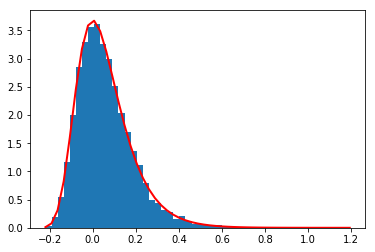

In [9]:
# Gumbel distribution

import numpy as np
import matplotlib.pyplot as plt

mu, theta = 0, 0.1
s = np.random.gumbel(mu, theta, 10000)

count, bins, ignored = plt.hist(s, bins=50, normed=True)
plt.plot(bins,
         (1/theta)*np.exp(-(bins-mu)/theta) * np.exp( -np.exp(-(bins-mu)/theta) ),
         linewidth=2, color='r' )
plt.show()

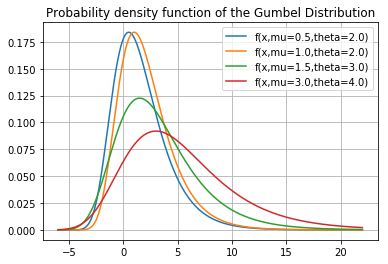

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def f(x,mu,theta):
    return (1/theta)*np.exp(-(x-mu)/theta) * np.exp( -np.exp(-(x-mu)/theta))

x = np.arange(-6,22,0.01)
for mu,theta in [(0.5,2.0), (1.0,2.0), (1.5,3.0), (3.0,4.0)]:
    plt.plot(x,f(x,mu,theta), label="f(x,mu={0},theta={1})".format(mu,theta))

plt.legend()
plt.title("Probability density function of the Gumbel Distribution")
plt.grid()
plt.show()

---
#### 別名法 （alias method）
単語数を $N$ 個としたとき、ガンベル最大トリックによって単語１つを無作為抽出するときの時間計算量は $O(N)$ である。

別名法では前処理に時間計算量 $O(N)$ 、空間計算量 $O(N)$ を使い、  
１回抽出する時間計算量は $O(1)$ となる。

$N$ 個の各要素に対し、それぞれの確率が $\{p_{1}, \ldots, o_{N}$ で与えられたとする。  
このとき、別名法における前処理のアルゴリズムは次の通り。

\begin{align*}
\hline
& \{q_{1}, \ldots, q_{N}\} \hspace{5pt} | \hspace{5pt} q_{i} = Np_{i} \\
& O = \{i|q_{i}>1\} \\
& U = \{i|q_{i} < 1\} \\
& \text{while} \hspace{5pt} |U|>0 \hspace{5pt} \text{do} \\
& \hspace{20pt} \text{Choose t from O and except from O} \\
& \hspace{20pt} \text{Choose s from U and except from U} \\
& \hspace{20pt} a_{s} := t \\
& \hspace{20pt} f_{s} := q_{s} \\
& \hspace{20pt} q_{t} := q_{t} - (1-q_{s}) \\
& \hspace{20pt} \text{if} \hspace{5pt} 1_{t} > 1 \hspace{5pt} \text{then} \\
& \hspace{40pt} \text{add t to O} \\
& \hspace{20pt} \text{else} \\
& \hspace{40pt} \text{add t to U} \\
& \hspace{20pt} \text{end if} \\
& \text{end while} \\
& \text{return} \hspace{5pt} \{f_{1}, \ldots, f_{N}\} , \{ a_{1}, \dots, a_{N} \} \\
\hline
\end{align*}

前処理によって表を構築した後の、別名法による無作為抽出のアルゴリズムは次の通り。

\begin{align*}
\hline
& r \sim U(0,1) \\
&k = rN \\
&p = rN-k \\
&\text{if} \hspace{5pt} p<f_{k} \hspace{5pt} \text{then} \\
&\hspace{20pt} \text{return} \hspace{5pt} k \\
&\text{else} \\
&\hspace{20pt} \text{return} \hspace{5pt} a_{k} \\
&\text{end if} \\
\hline
\end{align*}

　（参考：[基礎統計学III 自然科学の統計学](http://www.utp.or.jp/book/b300859.html)）

---
### 7.4　メモリ使用量の削減

